<h1> Food Brand </h1>
<hr>

The main objetive is given recommendations respect to the performance by Type (G Column):

<h2> Libraries </h2>
<hr>

First, I load the libraries requiered to do the analysis.

In [1]:
import pandas as pd
import numpy as np

import re
import textwrap
from unidecode import unidecode
import datetime as dt

from wordcloud import WordCloud, ImageColorGenerator

import matplotlib.pyplot as plt
import seaborn as sns

<h2> Load Data </h2>
<hr>

Now I load the database with the information:

In [2]:
df = pd.read_excel("Test_Data Analyst.xlsx")

In [3]:
for i in df.columns[df.dtypes == "float64"]:
    df[i] = df[i].fillna(0).astype(int)

After the load, we modify some variables that the format of this is wrong. Also, create a variable called <i> Week_Day </i> that has the weeks of the day that the activity was posted.

In [4]:
df["Channel"] = df["Channel"].apply(lambda x: textwrap.fill(x, 10))
df["Type"] = df["Type"].apply(lambda x: textwrap.fill(x, 10))
df["Country"] = df["Country"].apply(lambda x: textwrap.fill(x, 10))

df["Production Cost"] = df["Production Cost"].apply(lambda x: float(re.sub("\$", "", x)))
df["Total Cost"] = df["Total Cost"].apply(lambda x: (re.sub("\$|\,", "", x))).astype(float)
df["Media Investment"] = df["Media Investment"].apply(lambda x: float(re.sub("\$|\,", "", x)) if not pd.isna(x) else x)
df["Total Reach"] = df["Total Reach"].apply(lambda x: float(re.sub("\,", "", str(x)))).astype(float)
df["Total Impressions UBER"] = df["Total Impressions UBER"].apply(lambda x: float(re.sub("\,", "", str(x)))).astype(float)
df["CPM"] = df["CPM"].apply(lambda x: re.sub("\$|\,", "", str(x)) if not bool(re.match("\#", str(x))) else np.nan).astype(float)
df["Total Reach"] = df["Total Reach"].astype(float)
df["Pillar"] = df["Pillar"].apply(lambda x: re.sub("\s", "\n", re.sub("_", " ", x).title()))

Dias = ["Dom.", "Lun.", "Mar.", "Mie.", "Jue.", "Vie", "Sab."]
df["Week_Day"] = pd.Categorical(df["Date"].apply(lambda x: Dias[x.weekday()]), categories= Dias, ordered=True)

I work with the Top 10 of pillar, to see what's happening with this variable. I create a heatmat using the Type variable and cross with others:

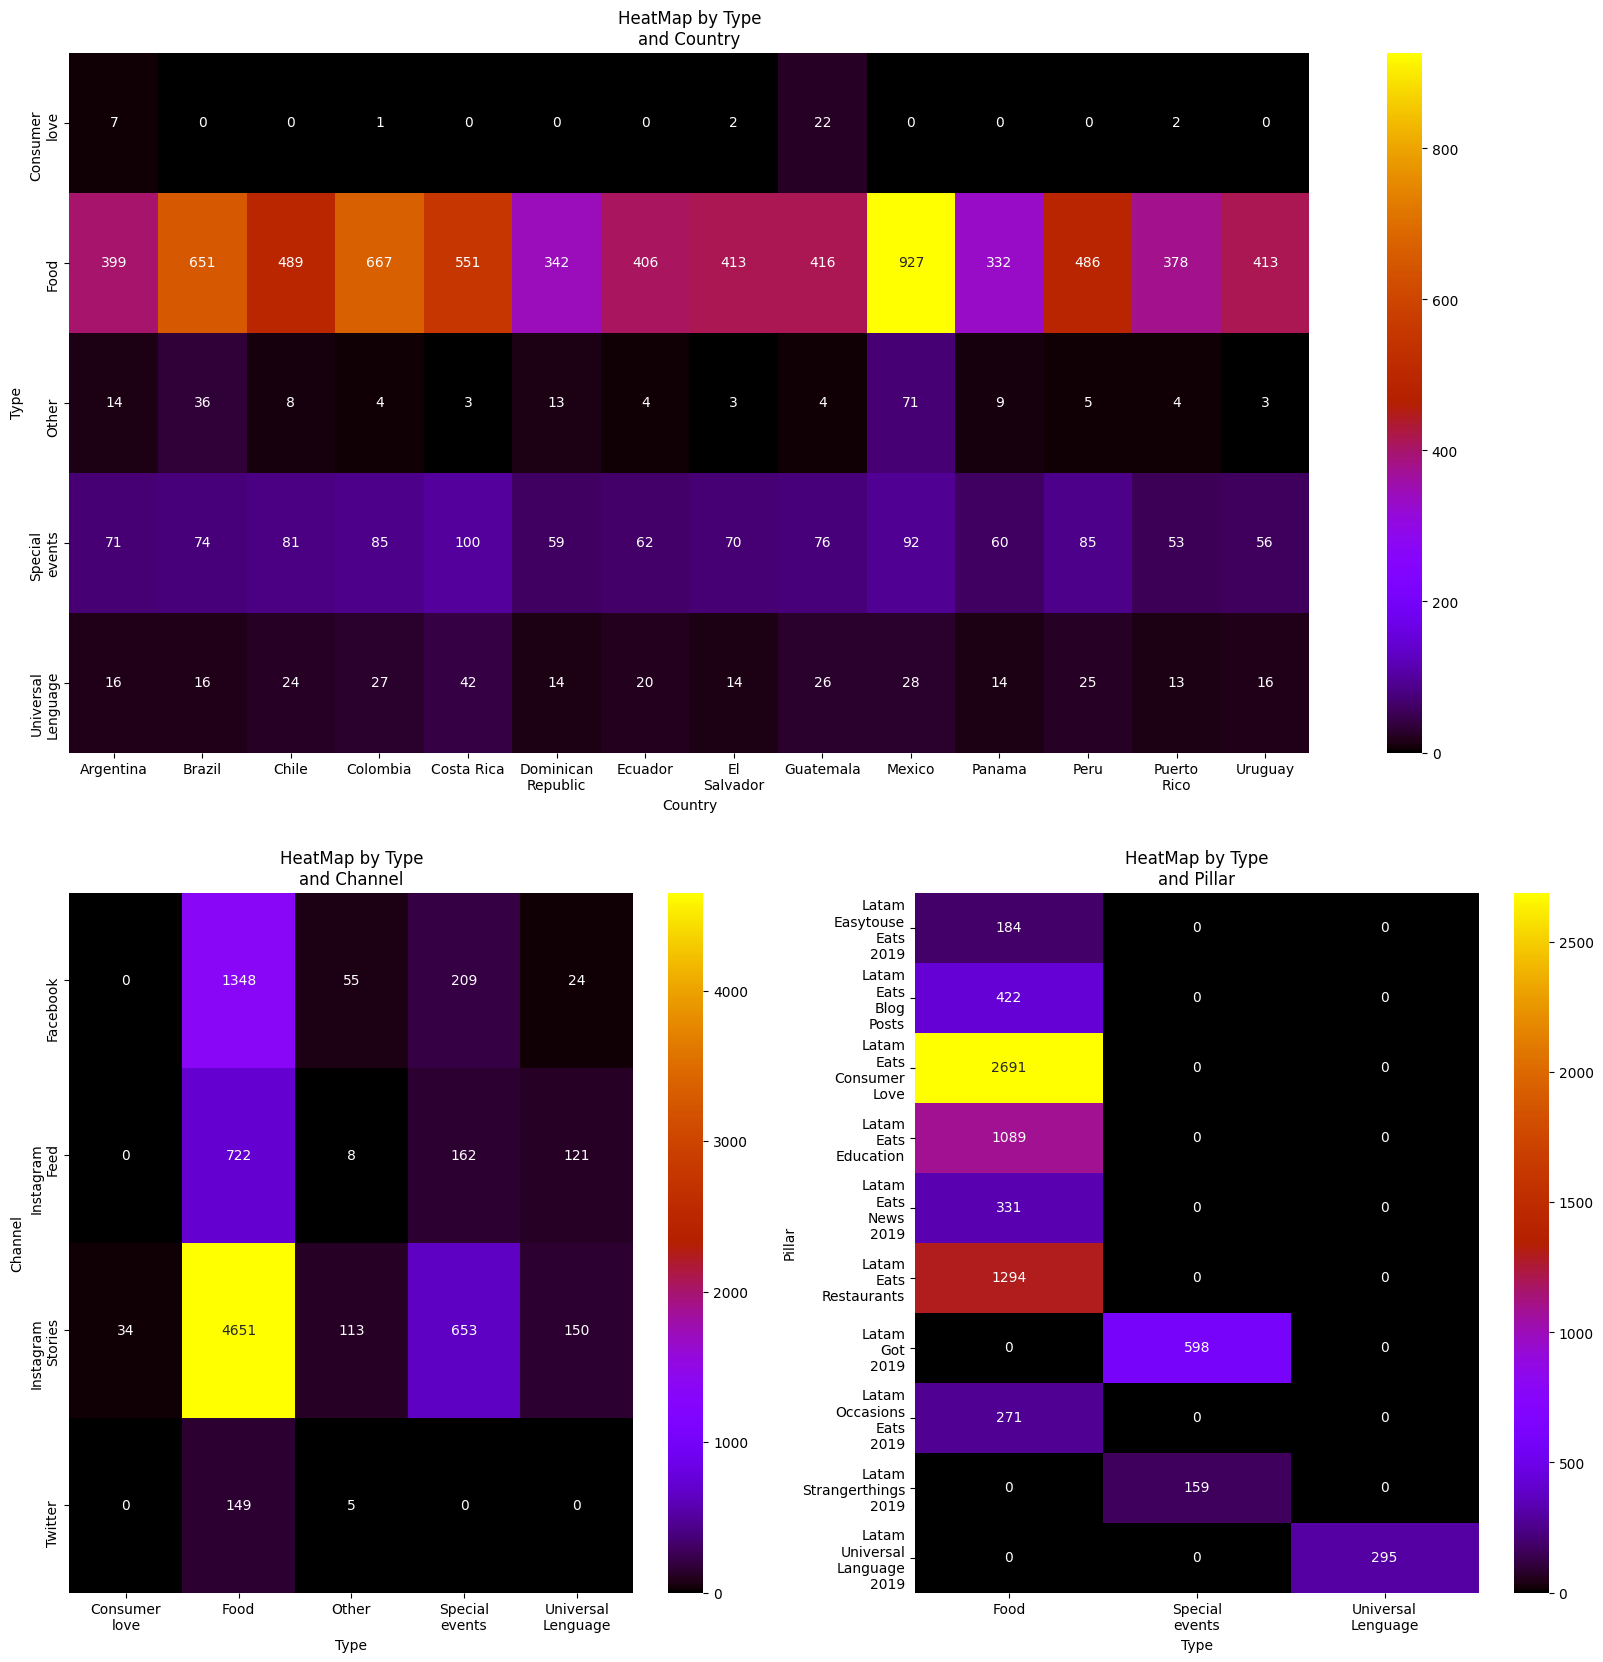

In [5]:
Top_10_Pillar = df["Pillar"].value_counts()[0:10].reset_index()["index"]

mosaic = [["A", "A"],
          ["B", "C"]]

fig, ax = plt.subplot_mosaic(mosaic, figsize = (20, 20))

sns.heatmap(
    df[["Country", "Type"]].
    value_counts().
    fillna(0).
    reset_index().
    rename({0: "Cantidad"}, axis=1).
    pivot_table(index="Type", columns="Country", values="Cantidad", fill_value = 0),
    annot=True,
    fmt='g',
    cmap="gnuplot",
    ax = ax["A"])

ax["A"].set_title("HeatMap by Type\nand Country")

sns.heatmap(
    df[["Channel", "Type"]].
    value_counts().
    fillna(0).
    reset_index().
    rename({0: "Cantidad"}, axis=1).
    pivot_table(index="Channel", columns="Type", values="Cantidad",
          fill_value = 0),
    cmap="gnuplot",
    annot=True,
    fmt='g',
    ax = ax["B"])

ax["B"].set_title("HeatMap by Type\nand Channel")

sns.heatmap(
    df[["Type", "Pillar"]].loc[df["Pillar"].isin(Top_10_Pillar)].
    value_counts().
    reset_index().
    rename({0: "Cantidad"}, axis=1).
    pivot_table(index="Pillar", columns="Type", values="Cantidad",
          fill_value = 0),
    cmap="gnuplot",
    annot=True,
    fmt='g',
    ax = ax["C"]
)

ax["C"].set_title("HeatMap by Type\nand Pillar")

plt.show()

The next plot, is the boxplot for each numeric value, using the <i> Type </i> variable:

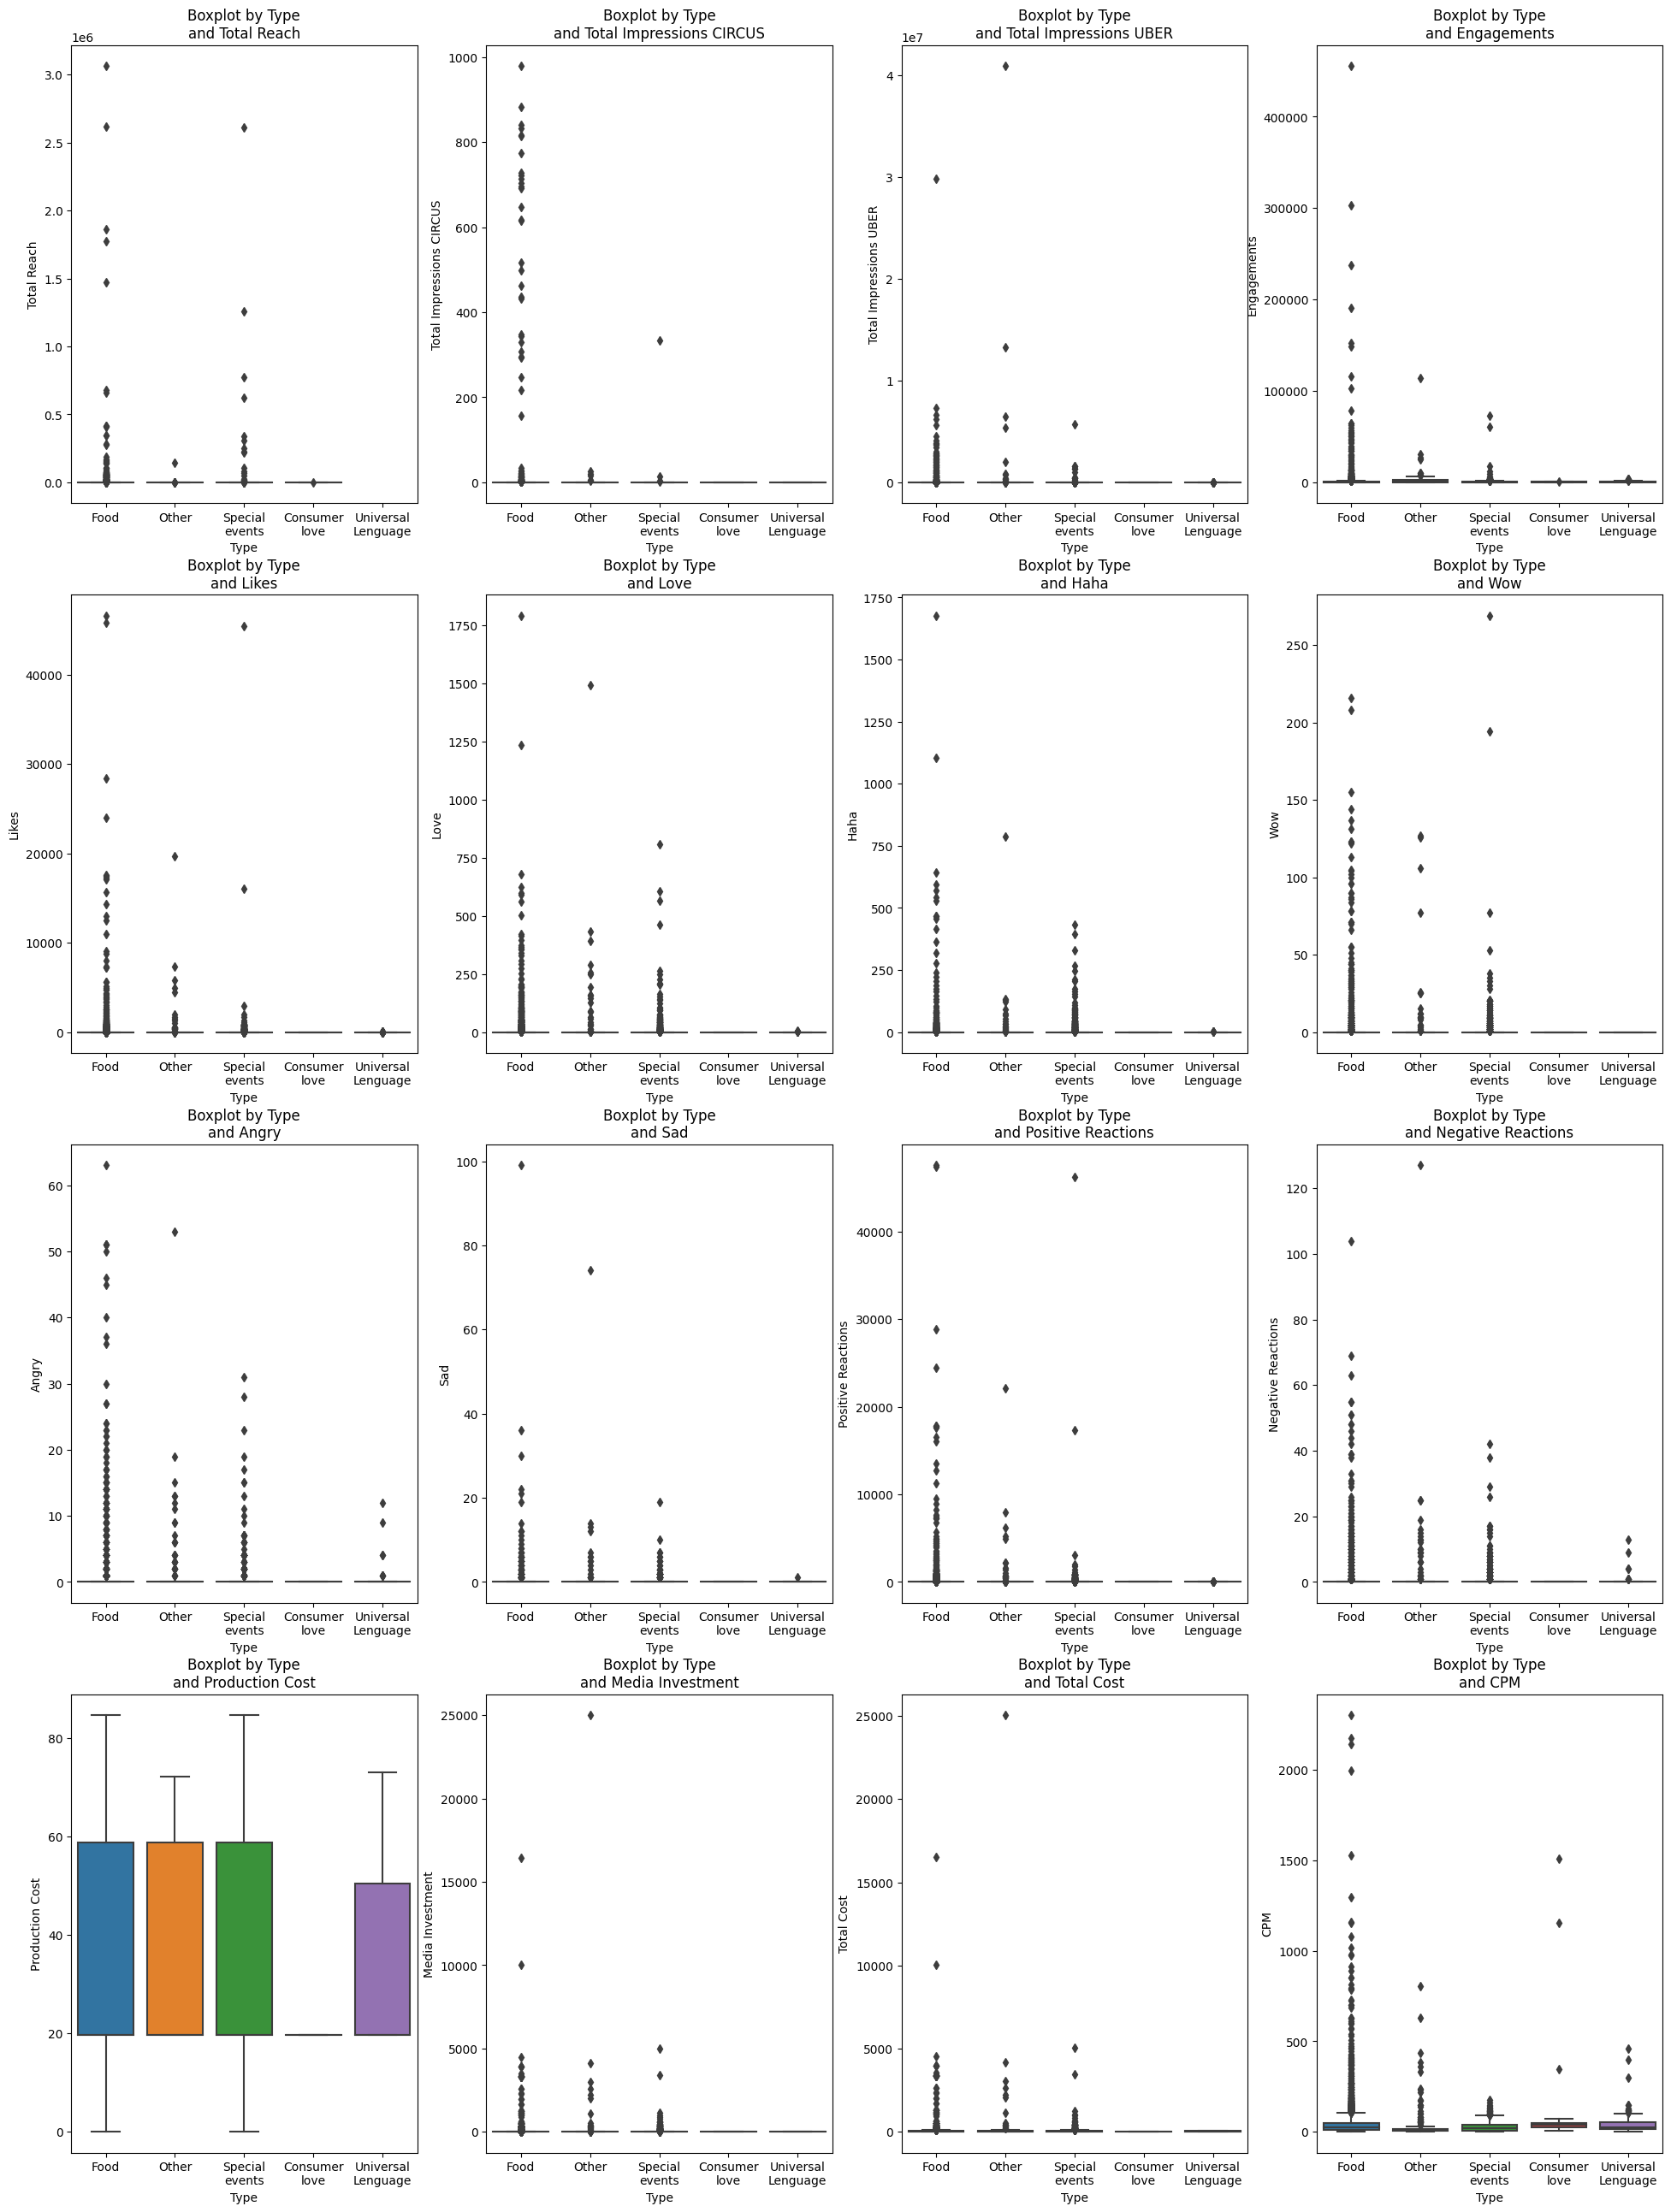

In [6]:
mosaic = []
for i in range(4):
    data = []
    for j in range(4):
        if (j % 4 != 0) | (j == 0):
            data.append(df.columns[(df.dtypes =="float64") | (df.dtypes =="int32")][i*4 + j])
    mosaic.append(data)

fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize = (24, 32))

for i in df.columns[(df.dtypes =="float64") | (df.dtypes =="int32")]:
    sns.boxplot(x = "Type", y = i, data=df, ax = ax[i])
    ax[i].set_title("Boxplot by Type\nand " + i) 

Finally, we create a table to see the behavior of each numeric variable according to the Type:

C:\Users\dags0\AppData\Local\Temp\ipykernel_3996\2622817933.py:6: FutureWarning: ['URL', 'Brand Post', 'Country', 'Sub Region', 'Channel', 'Pillar', 'Half', 'Month (F)', 'Month', 'Date', 'Semester', 'Week_Day'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  agg(


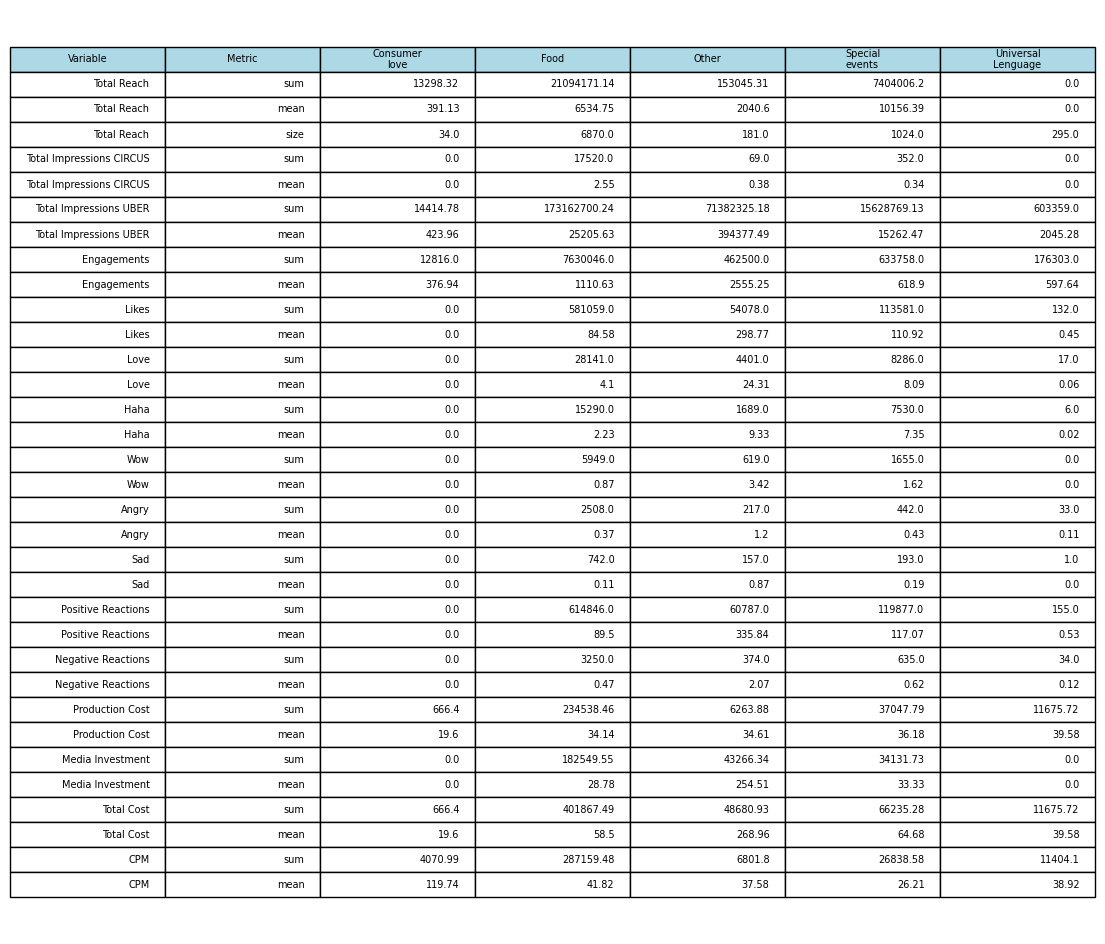

In [7]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
Tabla_Resumen = (
    df.
    drop("Year", axis=1).
    groupby("Type").
    agg(
        ["sum", "mean", "size"]
    ).
    fillna(0).
    apply(
        lambda x: np.round(x, 2)
    ).
    transpose().
    drop_duplicates().
    reset_index().
    rename({"level_0":"Variable", "level_1":"Metric"}, axis=1)
)

fig, ax = plt.subplots(1, 1, figsize =(14,12))
ax.table(cellText=Tabla_Resumen.values, colLabels=Tabla_Resumen.columns, loc = 'center', colColours=["lightblue" for i in Tabla_Resumen.columns]).scale(1,1.5)
ax.set_axis_off()

<h2> Word Cloud </h2>
<hr>

I created a <strong> Word Cloud </strong> for each Type using the <i> Brand Post </i>. The result is presented in the next image: 

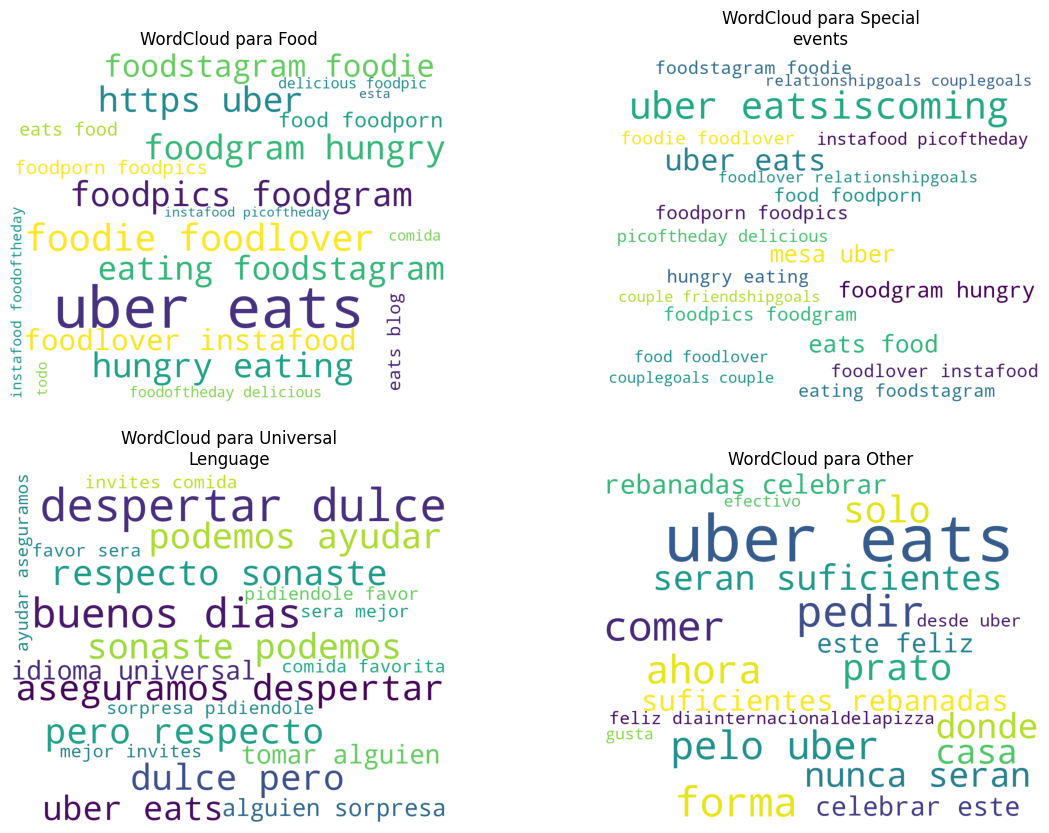

In [8]:
mosaic = [df["Type"].value_counts().reset_index()["index"].apply(lambda x: re.sub(r"\s", r"_", x)).to_list()[0:2],
          df["Type"].value_counts().reset_index()["index"].apply(lambda x: re.sub(r"\s", r"_", x)).to_list()[2:4]]

fig, ax = plt.subplot_mosaic(
    mosaic,
    figsize = (14,10)
)

for i in df["Type"].value_counts().reset_index()["index"].to_list()[0:4]:
    Text_General = re.sub(r'\s+', r' ', ' '.join(
        df.loc[df["Type"] == i]
        ["Brand Post"].apply(
        lambda x: re.sub(
            r'ubereats',
            r'uber eats',
            re.sub(
            r'como|para|tiene|message|text|hasta|esta\w+|aqui',
            r'',
            re.sub(
            r"\?|\!|\)",
            "",
            re.sub(
            r'\W*\b\w{1,3}\b',
            "",
            re.sub(
                r"\.\s*",
                " ",
                unidecode(x).lower()))
        )
        )
        )
    )))

    if len(Text_General) > 20:
        ax[re.sub(r"\s", r"_", i)].imshow(WordCloud(
            background_color='white',
            width = 1000,
            height = 800,
            max_words = 20).generate(Text_General))

        ax[re.sub(r"\s", r"_", i)].axis("off")
        ax[re.sub(r"\s", r"_", i)].set_title("WordCloud para " + i)

plt.show()